In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/instquality/")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/instquality/")

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Mean-reversion benchmark

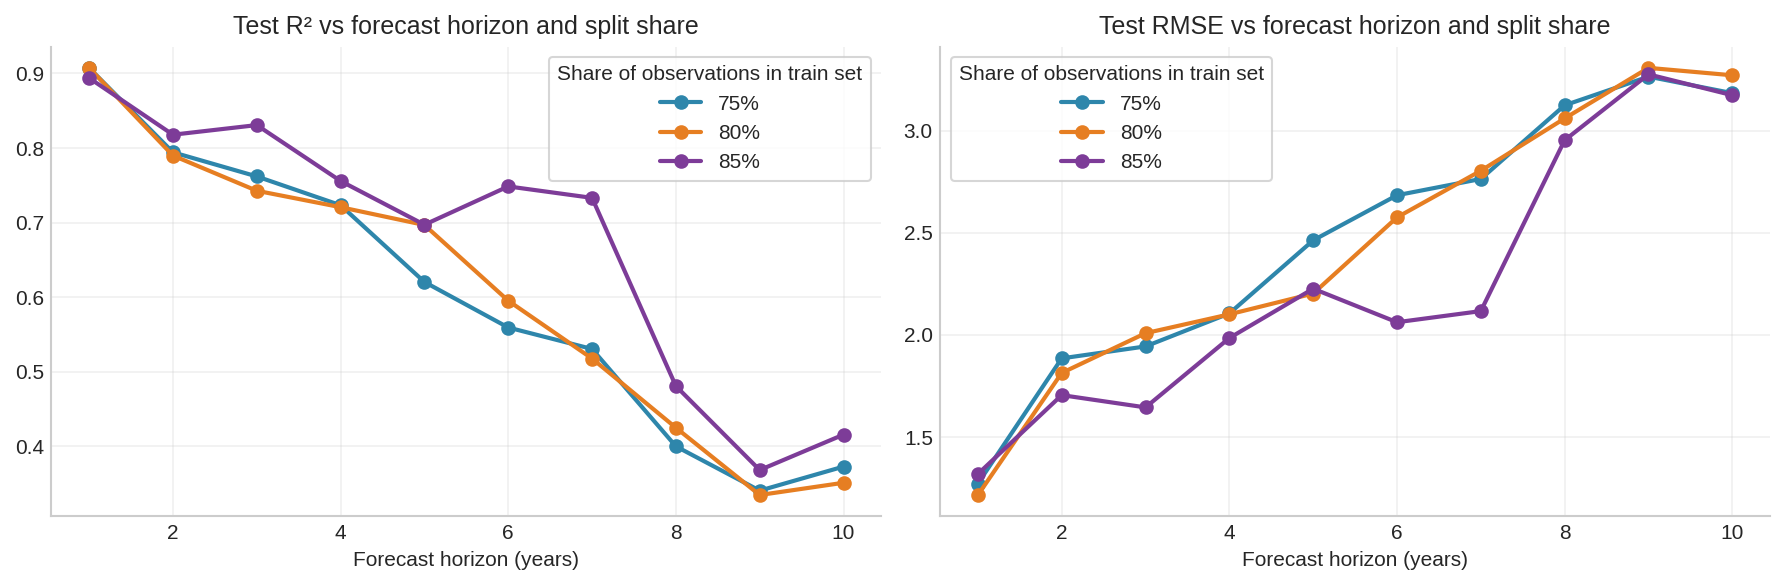

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from functions.utils import check_split_year  # ensure this is available

# Load data
df = pd.read_pickle("saved/df.dat")

shares = [0.75, 0.80, 0.85]
labels = {0.75: "25%", 0.80: "20%", 0.85: "15%"}
colors = {0.75: "#2E86AB", 0.80: "#E67E22", 0.85: "#7D3C98"}
records = []
for share in shares:
    for horizon in range(1, 11):
        y_col = f"tgt_spread_t{horizon}"
        if y_col not in df.columns:
            continue
        split_year = check_split_year(df, y_col, share=share)
        subset = df[["year", "tgt_spread", y_col]].dropna()
        test = subset[subset["year"] > split_year]
        if test.empty:
            continue
        y_true = test[y_col]
        y_pred = test["tgt_spread"]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        records.append(
            {
                "horizon": horizon,
                "split_share": share,
                "split_year": int(split_year),
                "rmse": rmse,
                "r2": r2,
            }
        )

results_df = pd.DataFrame(records)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
ax = axes[0]
for s in shares:
    part = results_df[results_df["split_share"] == s].sort_values("horizon")
    ax.plot(
        part["horizon"],
        part["r2"],
        marker="o",
        lw=2,
        color=colors[s],
        label=labels[s],
    )
ax.set_xlabel("Forecast horizon (years)")
ax.set_title("Test R² vs forecast horizon and split share")
ax.grid(True, alpha=0.3)
ax.legend(frameon=True, title='Share of observations in test set')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax = axes[1]
for s in shares:
    part = results_df[results_df["split_share"] == s].sort_values("horizon")
    ax.plot(
        part["horizon"],
        part["rmse"],
        marker="o",
        lw=2,
        color=colors[s],
        label=labels[s],
    )
ax.set_xlabel("Forecast horizon (years)")
ax.set_title("Test RMSE vs forecast horizon and split share")
ax.grid(True, alpha=0.3)
ax.legend(frameon=True, title='Share of observations in test set')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

### Summary

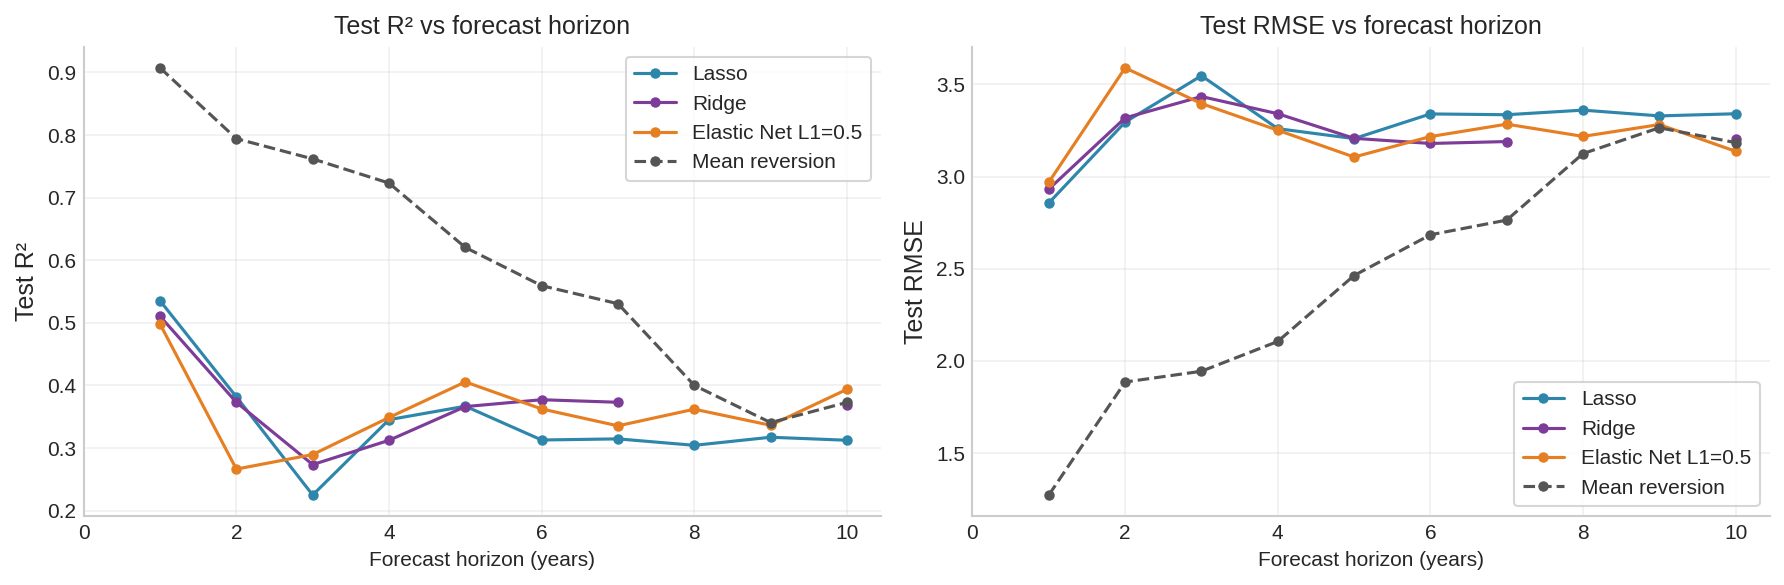

In [ ]:
import pandas as pd

from functions.summary import get_prediction_stats, get_benchmark_stats, plot_temporal_stats

df = pd.read_pickle("saved/df.dat")
specs_dir = "specs"
base_name = "levels"
suffix = "_agn_clust"

summary_df = get_prediction_stats(specs_dir, base_name, suffix)
benchmark_df = get_benchmark_stats(df, split_share=0.75)

plot_temporal_stats(summary_df, benchmark_df)

In [ ]:
from functions.summary import print_temporal_stats

print_temporal_stats(summary_df, benchmark_df)

Test‑set R² by Horizon                                         Test‑set RMSE by Horizon
-----------------------------------------------------------------------------------------------------------------------------
model    elastic net L1=0.5  lasso ridge  mean reversion       model    elastic net L1=0.5  lasso ridge  mean reversion
horizon                                                        horizon                                                 
1                     0.498  0.535 0.511           0.907       1                     2.969  2.857 2.932           1.273
2                     0.266  0.382 0.373           0.794       2                     3.589  3.295 3.318           1.886
3                     0.290  0.225 0.274           0.762       3                     3.395  3.547 3.434           1.944
4                     0.349  0.345 0.312           0.723       4                     3.251  3.260 3.341           2.106
5                     0.406  0.367 0.366           0.620       5  

### Function

In [4]:
import os, time
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from IPython.display import display
from joblib import Parallel, delayed
import shap
import warnings

def filter_cols(cols, exclude_endings):
    return [c for c in cols if not any(c.endswith(ending) for ending in exclude_endings)]

def _yearwise_splits(years, min_train_years=8, stride=2):
    ys = np.asarray(years)
    uniq = np.sort(np.unique(ys))
    for k in range(min_train_years, len(uniq), stride):
        train = np.where(np.isin(ys, uniq[:k]))[0]
        val = np.where(ys == uniq[k])[0]
        yield train, val

def _rmse_for_param(param, X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2):
    rmse = []
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3, warm_start=False)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    for tr, va in _yearwise_splits(years, min_train_years, stride):
        model.fit(X.iloc[tr], y.iloc[tr])
        pred = model.predict(X.iloc[va])
        rmse.append(np.sqrt(mean_squared_error(y.iloc[va], pred)))
    return param, float(np.mean(rmse)) if rmse else np.inf

def choose_param_expanding_fast(X, y, years, model_type='lasso', l1_ratio=0.5, min_train_years=8, stride=2, n_jobs=-1):
    if model_type == 'lasso':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            lasso_cv = LassoCV(alphas=alphas, cv=cv_folds, max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            lasso_cv.fit(X, y)
            return lasso_cv.alpha_

    elif model_type == 'elastic':
        alphas = np.logspace(-4, 1, 20)
        cv_folds = []
        for tr, va in _yearwise_splits(years, min_train_years, stride):
            cv_folds.append((tr, va))

        if len(cv_folds) > 0:
            elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=[l1_ratio], cv=cv_folds,
                                    max_iter=2000, tol=1e-3, n_jobs=n_jobs)
            elastic_cv.fit(X, y)
            return elastic_cv.alpha_

    params_coarse = np.logspace(0, 5, 15) if model_type == 'ridge' else np.logspace(-4, 1, 12)
    coarse = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(params_coarse, reverse=True)
    )
    p0 = min(coarse, key=lambda t: t[1])[0]
    low, high = p0/5, p0*5
    fine_grid = np.logspace(np.log10(low), np.log10(high), 8)
    fine = Parallel(n_jobs=n_jobs)(
        delayed(_rmse_for_param)(p, X, y, years, model_type, l1_ratio, min_train_years, stride)
        for p in sorted(fine_grid, reverse=True)
    )
    return min(fine, key=lambda t: t[1])[0]

def _fit_model_for_factor(factor, optimal_param, X_train, X_test, y_train_adj, y_test_adj,
                         y_train, y_test, spread_train, spread_test, model_type, l1_ratio, agnostic):
    param = optimal_param * factor
    if model_type == 'lasso':
        model = Lasso(alpha=param, max_iter=2000, tol=1e-3)
    elif model_type == 'ridge':
        model = Ridge(alpha=param)
    elif model_type == 'elastic':
        model = ElasticNet(alpha=param, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)

    model.fit(X_train, y_train_adj)
    y_pred_test_adj = model.predict(X_test)
    y_pred_train_adj = model.predict(X_train)

    if not agnostic:
        y_pred_test = spread_test + y_pred_test_adj
        y_pred_train = spread_train + y_pred_train_adj
    else:
        y_pred_test = y_pred_test_adj
        y_pred_train = y_pred_train_adj

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    active_vars = np.sum(model.coef_ != 0)

    if not agnostic:
        e_benchmark = y_test - spread_test
        e_model = y_test - y_pred_test
        dm_stat, dm_p = _dm_test(e_benchmark, e_model)
    else:
        dm_stat, dm_p = np.nan, np.nan

    return {
        'factor': factor,
        'param': param,
        'R²_train': r2_train,
        'R²_test': r2_test,
        'RMSE_test': rmse_test,
        'Active_vars': active_vars,
        'DM_stat': dm_stat,
        'DM_p': dm_p,
        'model': model,
        'predictions': y_pred_test
    }

def _dm_test(e0, e1):
    d = e0**2 - e1**2
    T = len(d)
    v = np.var(d, ddof=1)
    if T < 2 or v == 0 or np.isnan(v):
        return np.nan, np.nan
    stat = d.mean() / np.sqrt(v / T)
    pval = 2 * (1 - norm.cdf(abs(stat)))
    return stat, pval

def cluster_features(X_train, y_train=None, corr_threshold=0.75, method='complete'):
    def extract_core(var):
        suffixes = ['_delta3', '_delta', '_t-5', '_t-3', '_t-2', '_t-1', '_ma10', '_ma5', '_ma3']
        for s in suffixes:
            if var.endswith(s):
                return var[:-len(s)]
        return var

    core_groups = {}
    for v in X_train.columns:
        core = extract_core(v)
        core_groups.setdefault(core, []).append(v)

    cluster_map = {}
    representative_vars = []
    cluster_id = 0
    cluster_records = []

    for core, vars_in_core in core_groups.items():
        if len(vars_in_core) == 1:
            cluster_id += 1
            var = vars_in_core[0]
            cluster_map[cluster_id] = [var]
            representative_vars.append(var)
            cluster_records.append({'variable': var, 'cluster': cluster_id})
            continue

        corr_matrix = X_train[vars_in_core].corr().abs()
        corr_matrix = corr_matrix.fillna(0).clip(0, 1)
        distance_matrix = 1 - corr_matrix
        distance_matrix = np.where(np.isfinite(distance_matrix), distance_matrix, 1.0)
        condensed_dist = squareform(distance_matrix, checks=False)
        linkage_matrix = linkage(condensed_dist, method=method)
        clusters = fcluster(linkage_matrix, t=1 - corr_threshold, criterion='distance')

        for subcluster_id in np.unique(clusters):
            cluster_id += 1
            cluster_vars = [vars_in_core[i] for i, c in enumerate(clusters) if c == subcluster_id]
            cluster_map[cluster_id] = cluster_vars

            if y_train is not None:
                corrs = X_train[cluster_vars].corrwith(y_train)
                rep_var = corrs.abs().idxmax()
            else:
                variances = X_train[cluster_vars].var()
                rep_var = variances.idxmax()

            # Guard against NaN representative (can occur if correlation/variance all NaN)
            if pd.isna(rep_var):
                print(f"Warning: cluster {cluster_id} had no valid representative (NaN values), skipping it.")
                continue
            representative_vars.append(rep_var)
            for v in cluster_vars:
                cluster_records.append({'variable': v, 'cluster': cluster_id})

    cluster_df = pd.DataFrame(cluster_records)
    return representative_vars, cluster_map, cluster_df

def extract_core_variable(var_name):
    suffixes = ['_delta3', '_delta', '_t-5', '_t-4', '_t-3', '_t-2', '_t-1',
                '_ma10', '_ma5', '_ma3']
    for suffix in suffixes:
        if var_name.endswith(suffix):
            return var_name[:-len(suffix)]
    return var_name

def aggregate_by_core_variable(importance_df):
    importance_df = importance_df.copy()
    importance_df['core_variable'] = importance_df['variable'].apply(extract_core_variable)

    agg_dict = {'variable': lambda x: list(x)}

    if 'shap_importance' in importance_df.columns:
        agg_dict['shap_importance'] = 'sum'
    if 'shap_importance_pct' in importance_df.columns:
        agg_dict['shap_importance_pct'] = 'sum'
    if 'selection_frequency' in importance_df.columns:
        agg_dict['selection_frequency'] = 'mean'
    if 'mean_coef' in importance_df.columns:
        agg_dict['mean_coef'] = 'mean'
    if 'std_coef' in importance_df.columns:
        agg_dict['std_coef'] = 'mean'

    core_agg = importance_df.groupby('core_variable').agg(agg_dict).reset_index()
    core_agg['n_variants'] = core_agg['variable'].apply(len)
    core_agg = core_agg.rename(columns={'variable': 'variants'})

    if 'shap_importance' in core_agg.columns:
        core_agg = core_agg.sort_values('shap_importance', key=abs, ascending=False)
    elif 'selection_frequency' in core_agg.columns:
        core_agg = core_agg.sort_values('selection_frequency', ascending=False)

    return core_agg

def identify_cross_variable_correlations(X, threshold=0.75):
    var_to_core = {var: extract_core_variable(var) for var in X.columns}

    corr_matrix = X.corr().abs()

    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]

            core1 = var_to_core[var1]
            core2 = var_to_core[var2]

            if core1 != core2 and corr_val > threshold:
                high_corr_pairs.append({
                    'core_variable_1': core1,
                    'core_variable_2': core2,
                    'correlation': corr_val
                })

    if not high_corr_pairs:
        return pd.DataFrame()

    pairs_df = pd.DataFrame(high_corr_pairs)

    pairs_df['pair'] = pairs_df.apply(
        lambda row: tuple(sorted([row['core_variable_1'], row['core_variable_2']])),
        axis=1
    )

    result = pairs_df.loc[pairs_df.groupby('pair')['correlation'].idxmax()].copy()
    result = result[['core_variable_1', 'core_variable_2', 'correlation']].sort_values('correlation', ascending=False)
    result = result.reset_index(drop=True)

    return result

def calculate_shap_importance(model, X_test, max_samples=500):
    X_sample = X_test if len(X_test) <= max_samples else X_test.sample(max_samples, random_state=42)

    if hasattr(model, 'coef_'):
        explainer = shap.LinearExplainer(model, X_sample)
    else:
        explainer = shap.Explainer(model.predict, X_sample)

    shap_values = explainer(X_sample)

    if hasattr(shap_values, 'values'):
        shap_vals = shap_values.values
    else:
        shap_vals = shap_values

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    shap_df = pd.DataFrame({
        'variable': X_test.columns,
        'shap_importance': mean_abs_shap,
        'shap_importance_pct': mean_abs_shap / mean_abs_shap.sum() * 100
    }).sort_values('shap_importance', ascending=False)

    return shap_df, shap_values

def stability_selection(X_train, y_train, model_type='lasso', alpha=None, l1_ratio=0.5,
                       n_iterations=100, subsample_frac=0.8, random_state=42):
    np.random.seed(random_state)
    n_samples = len(X_train)
    subsample_size = int(n_samples * subsample_frac)

    selection_counts = {col: 0 for col in X_train.columns}
    coef_values = {col: [] for col in X_train.columns}

    for i in range(n_iterations):
        idx = np.random.choice(n_samples, size=subsample_size, replace=False)
        X_sub = X_train.iloc[idx]
        y_sub = y_train.iloc[idx]

        if model_type == 'lasso':
            if alpha is None:
                model = LassoCV(max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = Lasso(alpha=alpha, max_iter=2000, tol=1e-3)
        elif model_type == 'elastic':
            if alpha is None:
                model = ElasticNetCV(l1_ratio=l1_ratio, max_iter=2000, tol=1e-3, n_jobs=-1, random_state=random_state+i)
            else:
                model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=2000, tol=1e-3)
        elif model_type == 'ridge':
            model = Ridge(alpha=alpha if alpha else 1.0)

        model.fit(X_sub, y_sub)

        for col, coef in zip(X_train.columns, model.coef_):
            if coef != 0:
                selection_counts[col] += 1
                coef_values[col].append(coef)

    stability_df = pd.DataFrame({
        'variable': X_train.columns,
        'selection_frequency': [selection_counts[col] / n_iterations for col in X_train.columns],
        'mean_coef': [np.mean(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'std_coef': [np.std(coef_values[col]) if coef_values[col] else 0 for col in X_train.columns],
        'n_selections': [selection_counts[col] for col in X_train.columns]
    }).sort_values('selection_frequency', ascending=False)

    stability_df['stable'] = stability_df['selection_frequency'] >= 0.8

    return stability_df

def run_unified_regularized_regression(
    name_prefix="base",
    data_path="saved/df.dat",
    macro_cols=None,
    iq_cols=None,
    y_name="tgt_spread",
    spread_col="tgt_spread",
    year_col="year",
    split_year=2015,
    model_types=['lasso', 'ridge', 'elastic'],
    agnostic=True,
    param_factors=[0.5, 1.0, 2.0],
    l1_ratios=[0.5],
    use_clustering=True,
    corr_threshold=0.85,
    use_expanding_cv=True,
    min_train_years=8,
    cv_stride=2,
    r2_benchmark=None,
    rmse_benchmark=None,
    early_stop_threshold=0.10,
    stability_iterations=100,
    save_results=True,
    output_dir="specs",
    n_jobs=-1,
    parallel_param_factors=True,
    compute_shap=True,
    max_shap_samples=500,
    force_interpretability=False,
    r2_convergence_threshold=1e-4,
    r2_convergence_count=3,
    multicollinearity_check=True,
    perform_interpretability=True,
):
    print(f"\n{'='*80}")
    print(f"UNIFIED REGULARIZED REGRESSION: {name_prefix.upper()}")
    print(f"Specification: {'Agnostic (β unrestricted)' if agnostic else 'β=1 (fixed at mean reversion)'}")
    print(f"Models: {', '.join([m.upper() for m in model_types])}")
    if 'elastic' in model_types:
        print(f"Elastic Net L1 ratios: {l1_ratios}")
    if use_clustering:
        print(f"Feature clustering: ON (threshold={corr_threshold})")
    if perform_interpretability:
        print(f"Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)")
    print(f"R² convergence: Stop after {r2_convergence_count} consecutive changes < {r2_convergence_threshold}")
    if force_interpretability:
        print("Force interpretability: ON (interpret even if DM test fails)")
    print(f"{'='*80}\n")
    start_time = time.time()

    # Load and prepare data
    df = pd.read_pickle(data_path)
    if agnostic:
        df = df[df[y_name].notna()]
    else:
        df = df[(df[y_name].notna()) & (df[spread_col].notna())]
    df[year_col] = df[year_col].astype(int)

    if macro_cols is None:
        macro_cols = []
    if iq_cols is None:
        iq_cols = []

    train_data = df[df[year_col] <= split_year].copy()
    test_data = df[df[year_col] > split_year].copy()

    print(f"Train: {train_data[year_col].min()}-{train_data[year_col].max()} ({len(train_data)} obs)")
    print(f"Test:  {test_data[year_col].min()}-{test_data[year_col].max()} ({len(test_data)} obs)\n")

    feature_cols = macro_cols + iq_cols
    if spread_col in feature_cols and not agnostic:
        feature_cols = [c for c in feature_cols if c != spread_col]

    X_train_raw = train_data[feature_cols].copy()
    X_test_raw = test_data[feature_cols].copy()
    y_train = train_data[y_name].copy()
    y_test = test_data[y_name].copy()
    years_train = train_data[year_col].values

    # Adjust dependent variable for non-agnostic mode (β=1)
    if not agnostic:
        if spread_col not in train_data.columns:
            raise ValueError(f"β=1 specification requires '{spread_col}' column")
        spread_train = train_data[spread_col].copy()
        spread_test = test_data[spread_col].copy()
        mask_train = spread_train.notna() & y_train.notna()
        mask_test = spread_test.notna() & y_test.notna()
        X_train_raw = X_train_raw.loc[mask_train]
        X_test_raw = X_test_raw.loc[mask_test]
        y_train = y_train.loc[mask_train]
        y_test = y_test.loc[mask_test]
        spread_train = spread_train.loc[mask_train]
        spread_test = spread_test.loc[mask_test]
        years_train = years_train[mask_train.values]
        y_train_adj = y_train - spread_train
        y_test_adj = y_test - spread_test

        print(f"β=1 specification active")
        print(f"After removing NaN: {len(y_train_adj)} train, {len(y_test_adj)} test obs")

        # Print benchmark if provided
        if r2_benchmark is not None or rmse_benchmark is not None:
            print(f"\nBenchmark metrics:")
            if r2_benchmark is not None:
                print(f"  R² (test): {r2_benchmark:.4f}")
            if rmse_benchmark is not None:
                print(f"  RMSE (test): {rmse_benchmark:.4f}")
        print()
    else:
        y_train_adj = y_train
        y_test_adj = y_test
        spread_train = None
        spread_test = None

    # Handle imputation
    cols_with_data = X_train_raw.columns[~X_train_raw.isna().all()]
    X_train_fit = X_train_raw[cols_with_data].copy()
    X_test_fit = X_test_raw[cols_with_data].copy()
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train_fit)
    X_test_imp = imputer.transform(X_test_fit)
    X_train_imp_df = pd.DataFrame(X_train_imp, index=X_train_fit.index, columns=cols_with_data)
    X_test_imp_df = pd.DataFrame(X_test_imp, index=X_test_fit.index, columns=cols_with_data)

    # Multicollinearity
    if multicollinearity_check:
        print(f"{'='*80}")
        print("MULTICOLLINEARITY DIAGNOSTICS (Core Variables Only)")
        print(f"{'='*80}\n")

        cross_corr = identify_cross_variable_correlations(X_train_imp_df, threshold=corr_threshold)
        if len(cross_corr) > 0:
            print(f"Found {len(cross_corr)} core variable pairs with correlation above {corr_threshold}:\n")
            display(cross_corr.head(20))
            print("\nNote: These correlations are reported for transparency.")
            print("Regularization handles multicollinearity. Interpretation focuses on stable patterns.\n")
        else:
            print(f"No cross-core-variable correlations above {corr_threshold} threshold.\n")

    # Clustering
    if use_clustering:
        print("Clustering variants of same variables...")
        representative_vars, cluster_map, cluster_df = cluster_features(
            X_train_imp_df, y_train_adj, corr_threshold=corr_threshold
        )
        print(f"  Original features: {len(X_train_imp_df.columns)}")
        print(f"  After clustering: {len(representative_vars)}")
        print(f"  Number of clusters: {len(cluster_map)}\n")
        X_train_clustered = X_train_imp_df[representative_vars]
        X_test_clustered = X_test_imp_df[representative_vars]
    else:
        X_train_clustered = X_train_imp_df
        X_test_clustered = X_test_imp_df
        cluster_map = {i: [col] for i, col in enumerate(X_train_imp_df.columns)}
        cluster_df = pd.DataFrame({'variable': X_train_imp_df.columns, 'cluster': range(len(X_train_imp_df.columns))})

    # Standardization
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train_clustered),
                           index=X_train_clustered.index,
                           columns=X_train_clustered.columns)
    X_test = pd.DataFrame(scaler.transform(X_test_clustered),
                          index=X_test_clustered.index,
                          columns=X_test_clustered.columns)
    feature_names = list(X_train.columns)
    print(f"Features used in models: {len(feature_names)}\n")

    # Main loop
    all_results = {}

    for model_type in model_types:
        if model_type == 'elastic':
            model_configs = [(model_type, l1_ratio) for l1_ratio in l1_ratios]
        else:
            model_configs = [(model_type, None)]

        for model_type, l1_ratio in model_configs:
            mname = model_type.upper() + (f" (L1={l1_ratio})" if l1_ratio is not None else "")
            print(f"\n{'-'*80}")
            print(f"RUNNING {mname}")
            print(f"{'-'*80}\n")

            # Select optimal parameter
            if use_expanding_cv:
                print("Selecting optimal parameter via expanding window CV...")
                optimal_param = choose_param_expanding_fast(
                    X_train, y_train_adj, years_train,
                    model_type=model_type, l1_ratio=(l1_ratio or 0.5),
                    min_train_years=min_train_years,
                    stride=cv_stride, n_jobs=n_jobs
                )
            else:
                if model_type == 'ridge':
                    params = np.logspace(0, 5, 20)
                else:
                    params = np.logspace(-4, 1, 20)
                best_score = -np.inf
                optimal_param = params[0]
                for p in params:
                    if model_type == 'lasso':
                        m = Lasso(alpha=p, max_iter=2000, tol=1e-3)
                    elif model_type == 'ridge':
                        m = Ridge(alpha=p)
                    elif model_type == 'elastic':
                        m = ElasticNet(alpha=p, l1_ratio=(l1_ratio or 0.5),
                                       max_iter=2000, tol=1e-3)
                    m.fit(X_train, y_train_adj)
                    score = m.score(X_train, y_train_adj)
                    if score > best_score:
                        best_score = score
                        optimal_param = p
            print(f"Optimal parameter: {optimal_param:.6f}\n")

            # Parameter scaling loop
            results_rows = []
            models = {}
            r2_history = []
            convergence_counter = 0

            for factor in param_factors:
                result = _fit_model_for_factor(
                    factor, optimal_param, X_train, X_test,
                    y_train_adj, y_test_adj, y_train, y_test,
                    spread_train, spread_test, model_type,
                    (l1_ratio or 0.5), agnostic
                )

                # Stop and do not include models with zero active variables
                if model_type in ['lasso', 'elastic'] and result['Active_vars'] == 0:
                    print(f"Stopping: model has 0 active variables at factor {factor}\n")
                    break

                results_rows.append({
                    k: v for k, v in result.items() if k not in ['model', 'predictions']
                })
                models[result['factor']] = (result['model'], result['predictions'])

                # Convergence check
                r2_test = result['R²_test']
                if len(r2_history) > 0:
                    r2_change = abs(r2_test - r2_history[-1])
                    if r2_change < r2_convergence_threshold:
                        convergence_counter += 1
                        if convergence_counter >= r2_convergence_count:
                            print(f"Early stopping: R² converged after {r2_convergence_count} iterations.\n")
                            break
                    else:
                        convergence_counter = 0
                r2_history.append(r2_test)

            if not results_rows:
                print(f"No valid results for {mname}, skipping...\n")
                continue

            results_df = pd.DataFrame(results_rows)
            display(results_df)

            # Identify best model by test R²
            best_idx = results_df['R²_test'].idxmax()
            best_row = results_df.iloc[best_idx]
            best_model, best_pred = models[best_row['factor']]

            # --- Summarize results ---
            print(f"\nBest {mname}:")
            print(f"  Parameter: {best_row['param']:.6f}")
            print(f"  R² (test): {best_row['R²_test']:.4f}")

            # Benchmark deltas
            if r2_benchmark is not None:
                delta_r2_pp = (best_row['R²_test'] - r2_benchmark) * 100
                print(f"  ΔR² vs benchmark: {delta_r2_pp:+.2f} p.p.")

            print(f"  RMSE (test): {best_row['RMSE_test']:.4f}")

            if rmse_benchmark is not None:
                delta_rmse = best_row['RMSE_test'] - rmse_benchmark
                print(f"  ΔRMSE vs benchmark: {delta_rmse:+.4f}")

            print(f"  Active vars: {int(best_row['Active_vars'])}")

            # Print active variable names for sparse models with few variables
            if model_type in ['lasso', 'elastic'] and 0 < int(best_row['Active_vars']) <= 10:
                active_vars = [name for name, coef in zip(feature_names, best_model.coef_) if coef != 0]
                print(f"  Active variables: {', '.join(active_vars)}")

            # DM test statistics
            if not agnostic and not np.isnan(best_row['DM_stat']):
                print(f"  DM test: stat={best_row['DM_stat']:.2f}, p={best_row['DM_p']:.3f}")
            print()

            # ALWAYS SAVE MAIN RESULTS
            if save_results:
                os.makedirs(output_dir, exist_ok=True)
                suffix = (
                    f"{'_agn' if agnostic else ''}"
                    f"{f'_l1_{l1_ratio}' if model_type == 'elastic' else ''}"
                    f"{'_clust' if use_clustering else ''}"
                )
                results_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_results.dat")
                pd.Series(best_model.coef_, index=feature_names).to_pickle(
                    f"{output_dir}/{model_type}_{name_prefix}{suffix}_coefs.dat"
                )
                if use_clustering:
                    cluster_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_clusters.dat")

            # --- Interpretability logic ---
            should_skip_interpretability = False
            skip_reason = None

            if not perform_interpretability:
                should_skip_interpretability = True
                skip_reason = "interpretability disabled by user"
            elif int(best_row['Active_vars']) == 0:
                should_skip_interpretability = True
                skip_reason = "model has 0 active variables"
            elif not agnostic and not force_interpretability:
                if np.isnan(best_row['DM_p']) or best_row['DM_p'] >= 0.05:
                    should_skip_interpretability = True
                    skip_reason = f"no significant incremental value over mean reversion benchmark (DM p={best_row['DM_p']:.3f})"
            elif best_row['DM_stat']<0 and best_row['DM_p']<0.05:
                should_skip_interpretability = True
                skip_reason = f"forecast errors differ significantly from benchmark (DM p={best_row['DM_p']:.3f}), but the sign indicates incremental noise"

            if should_skip_interpretability:
                print(f"Skipping interpretability analysis: {skip_reason}\n")
                if skip_reason and "benchmark" in skip_reason:
                    print("Interpretation: Macro/IQ variables do not provide statistically significant")
                    print("incremental predictive power beyond the mean reversion benchmark.\n")

                model_key = f"{model_type}_l1_{l1_ratio}" if l1_ratio is not None else model_type
                all_results[model_key] = {
                    'results_df': results_df,
                    'best_model': best_model,
                    'best_row': best_row,
                    'predictions': best_pred,
                    'skipped_interpretability': True,
                    'skip_reason': skip_reason
                }
                if l1_ratio is not None:
                    all_results[model_key]['l1_ratio'] = l1_ratio
                continue

            # --- Perform interpretability analysis ---
            print(f"\n{'='*80}")
            if agnostic:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES ARE PRICED IN?")
            else:
                print(f"INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?")
            print(f"({mname})")
            print(f"{'='*80}\n")

            # METHOD 1: SHAP
            print(f"{'='*80}")
            print(f"METHOD 1: SHAP VALUES (Feature Attribution)")
            print(f"{'='*80}\n")

            shap_df, core_shap = None, None
            if compute_shap:
                try:
                    print("Computing SHAP values...")
                    shap_df, shap_values = calculate_shap_importance(best_model, X_test, max_samples=max_shap_samples)

                    core_shap = aggregate_by_core_variable(shap_df)
                    core_shap_nonzero = core_shap[core_shap['shap_importance'] > 1e-6].copy()
                    if len(core_shap_nonzero) > 0:
                        print(f"\nTop {min(20, len(core_shap_nonzero))} core variables by SHAP importance:\n")
                        display(core_shap_nonzero.head(20))
                    else:
                        print("\nNo core variables with meaningful SHAP importance\n")
                except Exception as e:
                    print(f"SHAP computation failed: {str(e)}")
                    print("Skipping SHAP analysis...\n")

            # METHOD 2: Stability Selection
            print(f"\n{'='*80}")
            print(f"METHOD 2: STABILITY SELECTION")
            print(f"{'='*80}\n")

            if model_type == 'ridge':
                print(f"Skipping stability selection for Ridge regression.")
                print("Ridge does not perform variable selection - all features have non-zero coefficients.")
                print("For feature importance with Ridge, refer to SHAP values above.\n")
                stability = None
                core_stability = None
            else:
                print(f"Running stability selection ({stability_iterations} iterations)...")
                stability = stability_selection(
                    X_train, y_train_adj,
                    model_type=model_type,
                    alpha=best_row['param'],
                    l1_ratio=(l1_ratio or 0.5),
                    n_iterations=stability_iterations
                )

                stability_stable = stability[stability['stable']].copy()
                if len(stability_stable) > 0:
                    core_stability = aggregate_by_core_variable(stability_stable)
                    print(f"\nCore variables with stable variants (aggregated from {len(stability_stable)} stable features):\n")
                    display(core_stability.head(20))
                else:
                    print("No variables meet stability criterion (80% selection frequency)\n")
                    core_stability = pd.DataFrame()

            # Save interpretability results
            if save_results:
                suffix = (
                    f"{'_agn' if agnostic else ''}"
                    f"{f'_l1_{l1_ratio}' if model_type == 'elastic' else ''}"
                    f"{'_clust' if use_clustering else ''}"
                )
                if shap_df is not None:
                    shap_df.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_shap.dat")
                    if core_shap is not None:
                        core_shap.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_shap.dat")
                if stability is not None:
                    stability.to_pickle(f"{output_dir}/{model_type}_{name_prefix}{suffix}_stability.dat")
                    if core_stability is not None and len(core_stability) > 0:
                        core_stability.to_pickle(
                            f"{output_dir}/{model_type}_{name_prefix}{suffix}_core_stability.dat"
                        )

            model_key = f"{model_type}_l1_{l1_ratio}" if l1_ratio is not None else model_type
            all_results[model_key] = {
                'results_df': results_df,
                'best_model': best_model,
                'best_row': best_row,
                'shap_importance': shap_df,
                'core_shap': core_shap,
                'stability_selection': stability,
                'core_stability': core_stability,
                'cross_correlations': cross_corr if multicollinearity_check else None,
                'cluster_map': cluster_map,
                'predictions': best_pred
            }
            if l1_ratio is not None:
                all_results[model_key]['l1_ratio'] = l1_ratio

    elapsed = time.time() - start_time
    print(f"\n{'='*80}")
    print(f"COMPLETED IN {elapsed:.1f}s")
    print(f"{'='*80}\n")
    return all_results

### Lagged priced-in level regressions (Prediction)

In [ ]:
import pandas as pd
from functions.utils import check_split_year

# Load
df = pd.read_pickle("saved/df.dat")

# Define
split_share = 0.8
id_cols = ["country","year","iso_code_1","iso_code_2","region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])

# For years 1 to 10
all_horizon_results = {}
for h in range(1, 11):
    # Get split year
    y_name = f"tgt_spread_t{h}"
    split_year = check_split_year(df, y_name, split_share)
    name_prefix = f"levels_t{h}_{share*100:.0f}"
    # Run the unified regression
    print("\n" + "=" * 100)
    print(f"Running forecast horizon: t+{h}")
    print(f"Split year for {share*100:.0f}-{(1-share)*100:.0f} split: {split_year}")
    results = run_unified_regularized_regression(
        name_prefix=name_prefix,
        data_path="saved/df.dat",
        macro_cols=macro_cols,
        iq_cols=iq_cols,
        use_clustering=True,
        corr_threshold=0.9,
        y_name=y_name,
        spread_col="tgt_spread",
        year_col="year",
        split_year=split_year,
        model_types=['lasso', 'ridge', 'elastic'],
        agnostic=True,
        param_factors=np.logspace(-2,5,15),
        l1_ratios=[0.5],
        use_expanding_cv=True,
        min_train_years=8,
        cv_stride=2,
        r2_benchmark=None,
        rmse_benchmark=None,
        early_stop_threshold=0.10,
        save_results=True,
        output_dir="specs",
        n_jobs=-1,
        multicollinearity_check=False
        perform_interpretability=False
    )
    all_horizon_results[f"t{h}"] = results
print("All horizon models completed.")

Horizon: t+1, Target: tgt_spread_t1, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T1_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2016 (1770 obs)
Test:  2017-2023 (413 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 634
Features used in models: 634


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 2.976351

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.029764,0.905757,0.551123,2.691992,350,NaN,NaN
1,0.031623,0.094120,0.839137,0.576991,2.613272,235,NaN,NaN
2,0.100000,0.297635,0.667093,0.479719,2.898204,109,NaN,NaN
3,0.316228,0.941205,0.480260,0.408988,3.088931,46,NaN,NaN
4,1.000000,2.976351,0.265559,0.186304,3.624441,24,NaN,NaN
5,3.162278,9.412050,0.000000,-0.060382,4.137530,0,NaN,NaN
6,10.000000,29.763514,0.000000,-0.060382,4.137530,0,NaN,NaN
7,31.622777,94.120497,0.000000,-0.060382,4.137530,0,NaN,NaN
8,100.000000,297.635144,0.000000,-0.060382,4.137530,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.094120
  R² (test): 0.5770
  RMSE (test): 2.6133
  Active vars: 235


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",1.606145,8.403738,9
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-5, efw_2a_judi...",0.906029,4.740564,5
74,ief_monetary_freedom,"[ief_monetary_freedom_ma3, ief_monetary_freedo...",0.802652,4.199671,7
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma5, efw_1b_tr...",0.766658,4.011342,6
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma1...,0.474375,2.482045,7
97,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta3, ...",0.472547,2.472480,3
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma5, wb_bn_cab_xoka_gd_z...",0.420997,2.202757,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.395610,2.069926,5
49,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-1, efw_5ci_regula...",0.384982,2.014317,7
19,efw_3b_standard_deviation_of_inflation,"[efw_3b_standard_deviation_of_inflation_ma10, ...",0.378717,1.981539,8



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
8,efw_2e_legal_integrity,[efw_2e_legal_integrity_ma10],1.000000,-0.405811,0.065803,1
54,p5d_durable,[p5d_durable],1.000000,-0.332716,0.055324,1
62,wb_ne_trd_gnfs_zs,[wb_ne_trd_gnfs_zs_t-5],1.000000,-0.090430,0.037795,1
35,efw_5cii_bureacracy_costs,[efw_5cii_bureacracy_costs_t-3],1.000000,-0.117643,0.035644,1
34,efw_5ci_regulatory_burden,"[efw_5ci_regulatory_burden_t-1, efw_5ci_regula...",1.000000,0.157668,0.042595,2
29,efw_5bi_labor_regulations_and_minimum_wage,[efw_5bi_labor_regulations_and_minimum_wage],1.000000,0.116190,0.043816,1
39,efw_5dii_business_permits,[efw_5dii_business_permits_t-5],1.000000,-0.215277,0.047353,1
24,efw_4dii_capital_controls,[efw_4dii_capital_controls_ma10],1.000000,0.188753,0.049352,1
9,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.248308,0.045163,1
70,wb_tx_val_fuel_zs_un,[wb_tx_val_fuel_zs_un_ma3],1.000000,0.192847,0.062102,1



COMPLETED IN 112.4s

Horizon: t+2, Target: tgt_spread_t2, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T2_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2015 (1759 obs)
Test:  2016-2022 (413 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 650
Features used in models: 650


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 1.623777

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.016238,0.901349,0.422309,3.053920,418,NaN,NaN
1,0.031623,0.051348,0.841786,0.472091,2.919373,300,NaN,NaN
2,0.100000,0.162378,0.733768,0.423768,3.050063,177,NaN,NaN
3,0.316228,0.513483,0.519279,0.315367,3.324597,75,NaN,NaN
4,1.000000,1.623777,0.305875,0.236036,3.511934,43,NaN,NaN
5,3.162278,5.134833,0.007957,-0.043195,4.103862,4,NaN,NaN
6,10.000000,16.237767,0.000000,-0.061426,4.139567,0,NaN,NaN
7,31.622777,51.348329,0.000000,-0.061426,4.139567,0,NaN,NaN
8,100.000000,162.377674,0.000000,-0.061426,4.139567,0,NaN,NaN
9,316.227766,513.483291,0.000000,-0.061426,4.139567,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.051348
  R² (test): 0.4721
  RMSE (test): 2.9194
  Active vars: 300


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_delta3, wb_ny_gdp_mktp_k...",11.623079,30.081385,9
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",1.446271,3.743057,5
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",1.269810,3.286362,7
97,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta, w...",1.187543,3.073449,3
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma1...,0.869953,2.251502,7
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.864150,2.236484,6
74,ief_monetary_freedom,"[ief_monetary_freedom, ief_monetary_freedom_ma...",0.768077,1.987841,8
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,0.654005,1.692614,5
107,wgi_voiceandaccountability_estimate,"[wgi_voiceandaccountability_estimate_ma10, wgi...",0.627831,1.624873,3
20,efw_3d_foreign_currency_bank_accounts,"[efw_3d_foreign_currency_bank_accounts, efw_3d...",0.592159,1.532551,7



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
5,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,1.000,0.174550,0.056850,1
26,efw_4di_financial_openness,"[efw_4di_financial_openness_t-3, efw_4di_finan...",1.000,-0.296120,0.098607,2
22,efw_4bi_non_tariff_trade_barriers,[efw_4bi_non_tariff_trade_barriers_delta3],1.000,0.129816,0.056511,1
23,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma1...,1.000,-0.322900,0.102204,2
53,fiw_e,[fiw_e_delta3],1.000,0.304891,0.083592,1
65,p5d_durable,[p5d_durable],1.000,-0.419754,0.061162,1
39,efw_5bv_cost_of_worker_dismissal,[efw_5bv_cost_of_worker_dismissal_ma10],1.000,-0.369867,0.087949,1
40,efw_5bvi_conscription,[efw_5bvi_conscription_t-5],1.000,0.160268,0.061527,1
27,efw_4dii_capital_controls,[efw_4dii_capital_controls_ma10],1.000,0.250911,0.070399,1
69,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma3],1.000,-0.276962,0.081311,1



COMPLETED IN 127.0s

Horizon: t+3, Target: tgt_spread_t3, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T3_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2014 (1748 obs)
Test:  2015-2021 (413 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 656
Features used in models: 656


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.004833,0.840506,0.106214,3.798627,552,NaN,NaN
1,0.031623,0.015283,0.776704,0.137086,3.732448,459,NaN,NaN
2,0.100000,0.048329,0.688236,0.249092,3.481796,338,NaN,NaN
3,0.316228,0.152831,0.556443,0.295415,3.372693,206,NaN,NaN
4,1.000000,0.483293,0.364608,0.325890,3.298948,78,NaN,NaN
5,3.162278,1.528307,0.215004,0.250241,3.479132,38,NaN,NaN
6,10.000000,4.832930,0.018743,-0.019063,4.056118,6,NaN,NaN
7,31.622777,15.283067,0.000000,-0.062655,4.141963,0,NaN,NaN
8,100.000000,48.329302,0.000000,-0.062655,4.141963,0,NaN,NaN
9,316.227766,152.830673,0.000000,-0.062655,4.141963,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.483293
  R² (test): 0.3259
  RMSE (test): 3.2989
  Active vars: 78


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",2.219218,30.485613,9
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.595912,8.186096,7
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.532435,7.314112,6
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma10, efw_2a_jud...",0.511753,7.030002,5
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma3, efw_1b_tr...",0.399123,5.482786,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.306249,4.206978,5
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma3, wb_bn_cab_xoka_gd_z...",0.282500,3.880736,7
28,efw_4bii_costs_of_importing_and_exporting,"[efw_4bii_costs_of_importing_and_exporting, ef...",0.265202,3.643103,6
33,efw_4diii_freedom_of_foreigners_to_visit,"[efw_4diii_freedom_of_foreigners_to_visit_ma3,...",0.215084,2.954631,4
97,wb_ny_gdp_pcap_kd,"[wb_ny_gdp_pcap_kd, wb_ny_gdp_pcap_kd_delta3, ...",0.196686,2.701900,3



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
5,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",1.000000,-0.266268,0.039659,2
23,wb_ny_gdp_minr_rt_zs,[wb_ny_gdp_minr_rt_zs_ma10],1.000000,0.145054,0.026066,1
20,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_ma3]",1.000000,-0.205259,0.038271,2
1,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies_ma3, efw_1b_tr...",0.995000,0.166180,0.046408,2
18,ief_monetary_freedom,[ief_monetary_freedom],0.990000,-0.270227,0.115162,1
13,efw_4di_financial_openness,[efw_4di_financial_openness_ma3],0.990000,-0.125393,0.036757,1
3,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.985000,-0.194051,0.048890,2
12,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma5, efw_4...",0.985000,-0.243799,0.079581,2
19,p5d_durable,[p5d_durable],0.980000,-0.160325,0.045819,1
14,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_ma3],0.980000,-0.108143,0.034118,1



COMPLETED IN 99.1s

Horizon: t+4, Target: tgt_spread_t4, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T4_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2013 (1737 obs)
Test:  2014-2020 (413 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 658
Features used in models: 658


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.885867

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.008859,0.674975,-0.228162,4.452848,519,NaN,NaN
1,0.031623,0.028014,0.606219,-42.747805,26.575909,399,NaN,NaN
2,0.100000,0.088587,0.486980,-85.491197,37.367664,267,NaN,NaN
3,0.316228,0.280136,0.326599,0.418156,3.064880,121,NaN,NaN
4,1.000000,0.885867,0.213066,0.362249,3.208747,38,NaN,NaN
5,3.162278,2.801357,0.112702,0.192881,3.609764,18,NaN,NaN
6,10.000000,8.858668,0.000000,-0.064009,4.144601,0,NaN,NaN
7,31.622777,28.013568,0.000000,-0.064009,4.144601,0,NaN,NaN
8,100.000000,88.586679,0.000000,-0.064009,4.144601,0,NaN,NaN
9,316.227766,280.135676,0.000000,-0.064009,4.144601,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.280136
  R² (test): 0.4182
  RMSE (test): 3.0649
  Active vars: 121


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",1.942313,18.635633,7
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-3, efw_2a_judi...",0.997698,9.572474,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma10, efw_2e_legal_int...",0.574258,5.509753,6
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.477265,4.579146,9
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.456938,4.384114,6
107,wgi_voiceandaccountability_estimate,"[wgi_voiceandaccountability_estimate_ma10, wgi...",0.404452,3.880542,4
2,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.294495,2.825553,6
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.278858,2.675519,6
92,wb_ne_trd_gnfs_zs,"[wb_ne_trd_gnfs_zs_delta3, wb_ne_trd_gnfs_zs_t...",0.262004,2.513812,3
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_delta3, efw_2b_impart...",0.243862,2.339746,5



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
7,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-5, efw_2e_legal_inte...",1.000000,-0.242621,0.053835,3
8,efw_2f_contracts,[efw_2f_contracts_delta3],1.000000,-0.131505,0.044772,1
16,efw_5ai_ownership_of_banks,[efw_5ai_ownership_of_banks_ma10],1.000000,0.230150,0.055675,1
38,wb_ny_gdp_pcap_kd,[wb_ny_gdp_pcap_kd_ma5],1.000000,-0.147297,0.047534,1
36,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.995000,0.139255,0.025978,2
9,efw_3_sound_money,[efw_3_sound_money_delta3],0.990000,-0.209436,0.072845,1
15,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit],0.990000,-0.099234,0.036335,1
39,wgi_ruleoflaw_estimate,[wgi_ruleoflaw_estimate_delta3],0.980000,0.167357,0.062065,1
14,efw_4di_financial_openness,"[efw_4di_financial_openness_ma3, efw_4di_finan...",0.980000,-0.116592,0.054890,2
1,efw_1b_transfers_and_subsidies,"[efw_1b_transfers_and_subsidies, efw_1b_transf...",0.975000,0.121000,0.056370,2



COMPLETED IN 104.4s

Horizon: t+5, Target: tgt_spread_t5, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T5_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2012 (1726 obs)
Test:  2013-2019 (413 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 657
Features used in models: 657


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.143845

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.001438,0.586270,-93.715770,39.103997,629,NaN,NaN
1,0.031623,0.004549,0.552653,-129.649049,45.926476,565,NaN,NaN
2,0.100000,0.014384,0.496657,-104.864450,41.341390,479,NaN,NaN
3,0.316228,0.045488,0.417657,-43.427608,26.781597,336,NaN,NaN
4,1.000000,0.143845,0.320645,0.420465,3.058790,198,NaN,NaN
5,3.162278,0.454878,0.220610,0.426798,3.042034,54,NaN,NaN
6,10.000000,1.438450,0.163607,0.288439,3.389348,23,NaN,NaN
7,31.622777,4.548778,0.030882,0.007304,4.003300,6,NaN,NaN
8,100.000000,14.384499,0.000000,-0.065245,4.147006,0,NaN,NaN
9,316.227766,45.487779,0.000000,-0.065245,4.147006,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.454878
  R² (test): 0.4268
  RMSE (test): 3.0420
  Active vars: 54


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma5, efw_2a_judi...",0.637204,18.036109,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma5, efw_2e_legal_inte...",0.502026,14.209898,6
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.463942,13.131907,5
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.217522,6.156987,5
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs, wb_bn_cab_xoka_gd_zs_ma...",0.193292,5.471153,8
58,efw_ie_state_ownership,"[efw_ie_state_ownership_ma10, efw_ie_state_own...",0.191283,5.414282,7
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.186660,5.283436,7
28,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma3...,0.173362,4.907024,5
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.154716,4.379249,6
57,efw_gender_disparity_index,"[efw_gender_disparity_index, efw_gender_dispar...",0.124358,3.519963,7



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
1,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,1.000,0.135460,0.031619,1
11,efw_5cii_bureacracy_costs,[efw_5cii_bureacracy_costs_delta3],1.000,-0.070586,0.023064,1
7,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma3, efw_4...",1.000,-0.361385,0.112917,2
4,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-3, efw_2e_legal_inte...",1.000,-0.296588,0.043121,2
2,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.995,-0.279773,0.073050,2
3,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma5, efw_2a_judi...",0.995,-0.377390,0.126226,2
6,efw_4bii_costs_of_importing_and_exporting,[efw_4bii_costs_of_importing_and_exporting_ma3],0.970,-0.122813,0.087760,1
0,efw_1b_transfers_and_subsidies,[efw_1b_transfers_and_subsidies],0.960,0.077645,0.041755,1
13,efw_ie_state_ownership,[efw_ie_state_ownership_ma10],0.950,-0.277877,0.149699,1
18,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.925,0.135380,0.022288,2



COMPLETED IN 104.0s

Horizon: t+6, Target: tgt_spread_t6, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T6_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2011 (1715 obs)
Test:  2012-2018 (413 obs)

Clustering variants of same variables...
  Original features: 972
  After clustering: 667
Features used in models: 667


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.004833,0.551550,-180.099417,54.071513,588,NaN,NaN
1,0.031623,0.015283,0.496494,-172.837988,52.976388,507,NaN,NaN
2,0.100000,0.048329,0.414688,-40.293511,25.819683,356,NaN,NaN
3,0.316228,0.152831,0.313095,-4.613823,9.520052,187,NaN,NaN
4,1.000000,0.483293,0.214183,0.386891,3.146145,51,NaN,NaN
5,3.162278,1.528307,0.160290,0.260465,3.455328,25,NaN,NaN
6,10.000000,4.832930,0.020897,-0.017515,4.053036,6,NaN,NaN
7,31.622777,15.283067,0.000000,-0.066276,4.149013,0,NaN,NaN
8,100.000000,48.329302,0.000000,-0.066276,4.149013,0,NaN,NaN
9,316.227766,152.830673,0.000000,-0.066276,4.149013,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.483293
  R² (test): 0.3869
  RMSE (test): 3.1461
  Active vars: 51


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-1, efw_2a_judi...",0.767018,23.791597,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma5, efw_2e_legal_inte...",0.501801,15.565014,7
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.494841,15.349141,6
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.252766,7.840387,5
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_...",0.199235,6.179937,8
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.192110,5.958922,7
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.191127,5.928428,6
18,efw_3a_money_growth,"[efw_3a_money_growth, efw_3a_money_growth_ma10...",0.090337,2.802110,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg_ma10, wb_ny_gdp_mktp_kd_...",0.079472,2.465088,9
92,wb_ne_trd_gnfs_zs,"[wb_ne_trd_gnfs_zs_delta, wb_ne_trd_gnfs_zs, w...",0.077332,2.398697,3



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,1.000000,0.162775,0.032267,1
3,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-3, efw_2e_legal_inte...",1.000000,-0.196785,0.041362,3
1,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.980000,-0.194432,0.056257,3
10,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_zs]",0.975000,-0.094447,0.035568,2
8,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.965000,-0.082111,0.036533,2
4,efw_3a_money_growth,"[efw_3a_money_growth_ma10, efw_3a_money_growth]",0.965000,-0.098350,0.049354,2
2,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-1, efw_2a_judi...",0.960000,-0.285806,0.100712,3
14,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.960000,0.111089,0.025163,3
11,wb_fp_cpi_totl_zg,[wb_fp_cpi_totl_zg_ma5],0.950000,0.097125,0.041560,1
5,efw_4c_black_market_exchange_rates,"[efw_4c_black_market_exchange_rates_ma3, efw_4...",0.936667,-0.275800,0.077743,3



COMPLETED IN 105.8s

Horizon: t+7, Target: tgt_spread_t7, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T7_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2010 (1704 obs)
Test:  2011-2017 (413 obs)

Clustering variants of same variables...
  Original features: 963
  After clustering: 661
Features used in models: 661


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.078476

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000785,0.581667,-257.679849,64.623623,648,NaN,NaN
1,0.031623,0.002482,0.562034,-292.071823,68.785521,619,NaN,NaN
2,0.100000,0.007848,0.518162,-242.021677,62.637225,552,NaN,NaN
3,0.316228,0.024816,0.447041,-88.674959,38.049206,430,NaN,NaN
4,1.000000,0.078476,0.362385,0.150234,3.703903,257,NaN,NaN
5,3.162278,0.248163,0.263419,0.367622,3.195202,115,NaN,NaN
6,10.000000,0.784760,0.188430,0.335188,3.276118,27,NaN,NaN
7,31.622777,2.481629,0.116611,0.187049,3.622781,13,NaN,NaN
8,100.000000,7.847600,0.000000,-0.067491,4.151377,0,NaN,NaN
9,316.227766,24.816289,0.000000,-0.067491,4.151377,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.248163
  R² (test): 0.3676
  RMSE (test): 3.1952
  Active vars: 115


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence, efw_2a_judicial...",1.155458,14.012551,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-1, efw_2e_legal_inte...",0.736276,8.929013,7
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.658042,7.980246,6
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_ma10, e...",0.463740,5.623895,7
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.462100,5.604006,7
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.406438,4.928988,5
45,efw_5bv_cost_of_worker_dismissal,"[efw_5bv_cost_of_worker_dismissal_t-5, efw_5bv...",0.299405,3.630959,5
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_delta3, wb_iq_spi_pil1, wb_iq_...",0.279295,3.387091,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_...",0.273964,3.322434,7
57,efw_gender_disparity_index,"[efw_gender_disparity_index_ma3, efw_gender_di...",0.227843,2.763111,7



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
26,p5d_autoc,[p5d_autoc_ma10],1.000000,-0.159257,0.054476,1
29,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma10],1.000000,-0.187619,0.057950,1
21,efw_5cii_bureacracy_costs,[efw_5cii_bureacracy_costs_t-1],1.000000,0.126178,0.025849,1
5,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma3, efw_2a_judi...",0.995000,-0.710168,0.224302,2
4,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.990000,-0.445050,0.146193,2
13,efw_4di_financial_openness,[efw_4di_financial_openness_ma3],0.990000,-0.112648,0.049451,1
33,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.986667,0.158320,0.038834,3
6,efw_2c_property_rights,[efw_2c_property_rights_delta3],0.980000,0.073786,0.036043,1
31,wb_ne_trd_gnfs_zs,"[wb_ne_trd_gnfs_zs_delta, wb_ne_trd_gnfs_zs_t-1]",0.980000,-0.028881,0.078105,2
14,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit],0.970000,-0.100005,0.037654,1



COMPLETED IN 108.9s

Horizon: t+8, Target: tgt_spread_t8, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T8_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2009 (1693 obs)
Test:  2010-2016 (413 obs)

Clustering variants of same variables...
  Original features: 960
  After clustering: 660
Features used in models: 660


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.004833,0.545208,-198.708816,56.781730,583,NaN,NaN
1,0.031623,0.015283,0.480774,-134.017998,46.688060,504,NaN,NaN
2,0.100000,0.048329,0.385113,-40.196472,25.789327,351,NaN,NaN
3,0.316228,0.152831,0.283855,0.321497,3.309678,187,NaN,NaN
4,1.000000,0.483293,0.191123,0.378034,3.168790,41,NaN,NaN
5,3.162278,1.528307,0.144805,0.248486,3.483201,16,NaN,NaN
6,10.000000,4.832930,0.019718,-0.021493,4.060950,6,NaN,NaN
7,31.622777,15.283067,0.000000,-0.068853,4.154025,0,NaN,NaN
8,100.000000,48.329302,0.000000,-0.068853,4.154025,0,NaN,NaN
9,316.227766,152.830673,0.000000,-0.068853,4.154025,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.483293
  R² (test): 0.3780
  RMSE (test): 3.1688
  Active vars: 41


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma3, efw_2a_judi...",0.757968,22.546078,5
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_t-1, efw_2e_legal_inte...",0.592620,17.627718,7
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.480180,14.283165,5
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.363968,10.826390,7
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma5, wb_ny_gdp_minr_rt_z...",0.285981,8.506614,6
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.218070,6.486576,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_...",0.182036,5.414735,7
18,efw_3a_money_growth,"[efw_3a_money_growth_ma10, efw_3a_money_growth...",0.118818,3.534300,8
101,wb_tx_val_fuel_zs_un,"[wb_tx_val_fuel_zs_un_t-5, wb_tx_val_fuel_zs_u...",0.094194,2.801830,4
15,efw_2g_real_property,"[efw_2g_real_property_delta3, efw_2g_real_prop...",0.055888,1.662408,6



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,1.000000,0.151368,0.043688,1
1,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000000,-0.292983,0.060180,2
3,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma3, efw_2e_legal_inte...",1.000000,-0.233505,0.043798,3
9,wb_bn_cab_xoka_gd_zs,[wb_bn_cab_xoka_gd_zs_ma10],1.000000,-0.124445,0.044435,1
2,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma3, efw_2a_judi...",0.995000,-0.399304,0.119146,2
4,efw_3a_money_growth,"[efw_3a_money_growth, efw_3a_money_growth_ma10...",0.986667,-0.106405,0.041485,3
10,wb_ne_trd_gnfs_zs,[wb_ne_trd_gnfs_zs_t-1],0.960000,-0.069264,0.027834,1
12,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma10, wb_ny_gdp_minr_rt_...",0.946667,0.106379,0.032619,3
13,wb_tx_val_fuel_zs_un,[wb_tx_val_fuel_zs_un_t-5],0.940000,0.120291,0.060926,1
7,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.933333,-0.093881,0.035890,3



COMPLETED IN 93.0s

Horizon: t+9, Target: tgt_spread_t9, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T9_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2008 (1682 obs)
Test:  2009-2015 (413 obs)

Clustering variants of same variables...
  Original features: 940
  After clustering: 651
Features used in models: 651


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.078476

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.000785,0.668053,-7.179695e+27,3.404576e+14,635,NaN,NaN
1,0.031623,0.002482,0.646928,-1.840124e+02,5.465255e+01,609,NaN,NaN
2,0.100000,0.007848,0.598117,-9.526866e+27,3.921796e+14,545,NaN,NaN
3,0.316228,0.024816,0.503634,-8.660017e+27,3.739120e+14,451,NaN,NaN
4,1.000000,0.078476,0.379023,-1.242200e+28,4.478224e+14,273,NaN,NaN
5,3.162278,0.248163,0.239984,3.147767e-01,3.326029e+00,103,NaN,NaN
6,10.000000,0.784760,0.164875,3.314770e-01,3.285248e+00,27,NaN,NaN
7,31.622777,2.481629,0.104659,1.801484e-01,3.638125e+00,8,NaN,NaN
8,100.000000,7.847600,0.000000,-7.063280e-02,4.157481e+00,0,NaN,NaN
9,316.227766,24.816289,0.000000,-7.063280e-02,4.157481e+00,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.784760
  R² (test): 0.3315
  RMSE (test): 3.2852
  Active vars: 27


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_t-3, efw_2a_judi...",0.839602,35.783057,6
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma3, efw_2e_legal_inte...",0.498069,21.227224,7
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.343914,14.657273,6
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma5, wb_ny_gdp_minr_rt_z...",0.180931,7.711086,6
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.122177,5.207088,7
18,efw_3a_money_growth,"[efw_3a_money_growth_ma10, efw_3a_money_growth...",0.091237,3.888435,8
10,efw_2b_impartial_courts,"[efw_2b_impartial_courts_ma10, efw_2b_impartia...",0.079703,3.396881,5
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.068283,2.910148,7
101,wb_tx_val_fuel_zs_un,"[wb_tx_val_fuel_zs_un_t-5, wb_tx_val_fuel_zs_u...",0.053492,2.279773,4
8,efw_2_legal_system_property_rights_with_gender...,[efw_2_legal_system_property_rights_with_gende...,0.025530,1.088079,6



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
1,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000,-0.415898,0.057259,1
4,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma3, efw_2e_legal_inte...",1.000,-0.295232,0.040768,2
9,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_t-3, wb_ny_gdp_minr_rt_z...",0.995,0.087646,0.027015,2
2,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma3, efw_2a_judi...",0.970,-0.322252,0.084624,3
5,efw_3a_money_growth,"[efw_3a_money_growth_ma10, efw_3a_money_growth...",0.950,-0.087272,0.032274,3
8,efw_5biii_flexible_wage_determination,[efw_5biii_flexible_wage_determination_t-5],0.950,-0.069994,0.031782,1
0,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.930,0.048151,0.029722,1
3,efw_2b_impartial_courts,[efw_2b_impartial_courts_ma10],0.910,-0.092500,0.059826,1
6,efw_4c_black_market_exchange_rates,[efw_4c_black_market_exchange_rates],0.890,-0.210246,0.065550,1
10,wb_tx_val_fuel_zs_un,[wb_tx_val_fuel_zs_un_t-5],0.860,0.074631,0.041959,1



COMPLETED IN 103.5s

Horizon: t+10, Target: tgt_spread_t10, Split year: 2009

UNIFIED REGULARIZED REGRESSION: LEVELS_T10_80.0
Specification: Agnostic (β unrestricted)
Models: ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (if interpretability ON)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2007 (1670 obs)
Test:  2008-2014 (413 obs)

Clustering variants of same variables...
  Original features: 934
  After clustering: 653
Features used in models: 653


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.483293

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.010000,0.004833,0.480033,-1.183199e+29,1.382098e+15,574,NaN,NaN
1,0.031623,0.015283,0.426426,-5.473577e+29,2.972662e+15,470,NaN,NaN
2,0.100000,0.048329,0.344603,-3.644849e+29,2.425771e+15,327,NaN,NaN
3,0.316228,0.152831,0.253530,3.804039e-01,3.162746e+00,165,NaN,NaN
4,1.000000,0.483293,0.173337,3.948665e-01,3.125616e+00,47,NaN,NaN
5,3.162278,1.528307,0.120587,2.377116e-01,3.508081e+00,16,NaN,NaN
6,10.000000,4.832930,0.008319,-5.357921e-02,4.124237e+00,2,NaN,NaN
7,31.622777,15.283067,0.000000,-7.308952e-02,4.162248e+00,0,NaN,NaN
8,100.000000,48.329302,0.000000,-7.308952e-02,4.162248e+00,0,NaN,NaN
9,316.227766,152.830673,0.000000,-7.308952e-02,4.162248e+00,0,NaN,NaN



Best ELASTIC (L1=0.5):
  Parameter: 0.483293
  R² (test): 0.3949
  RMSE (test): 3.1256
  Active vars: 47


INTERPRETABILITY ANALYSIS (ELASTIC (L1=0.5))

--------------------------------------------------------------------------------
METHOD 1: SHAP VALUES
--------------------------------------------------------------------------------

Top core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
9,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma3, efw_2a_judi...",1.311366,32.534786,6
43,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-3, ef...",0.483538,11.996510,7
94,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma5, wb_ny_gdp_minr_rt_z...",0.360196,8.936403,6
6,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,0.309065,7.667845,7
7,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,0.228627,5.672197,6
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_...",0.190745,4.732359,8
101,wb_tx_val_fuel_zs_un,"[wb_tx_val_fuel_zs_un_ma5, wb_tx_val_fuel_zs_u...",0.156264,3.876884,4
18,efw_3a_money_growth,"[efw_3a_money_growth_ma10, efw_3a_money_growth...",0.135710,3.366941,7
96,wb_ny_gdp_pcap_cd,"[wb_ny_gdp_pcap_cd_delta3, wb_ny_gdp_pcap_cd_t...",0.129740,3.218837,3
13,efw_2e_legal_integrity,"[efw_2e_legal_integrity_ma3, efw_2e_legal_inte...",0.108904,2.701898,7



--------------------------------------------------------------------------------
METHOD 2: STABILITY SELECTION
--------------------------------------------------------------------------------

Stable variables (aggregated):


,core_variable,variants,selection_frequency,mean_coef,std_coef,n_variants
0,efw_1dii_top_marginal_income_and_payroll_tax_rate,[efw_1dii_top_marginal_income_and_payroll_tax_...,1.000,0.131261,0.030296,2
1,efw_2_legal_system_property_rights_no_gender_a...,[efw_2_legal_system_property_rights_no_gender_...,1.000,-0.205847,0.132943,1
15,wb_ny_gdp_pcap_cd,[wb_ny_gdp_pcap_cd_delta3],1.000,-0.124120,0.025999,1
14,wb_ny_gdp_minr_rt_zs,"[wb_ny_gdp_minr_rt_zs_ma5, wb_ny_gdp_minr_rt_z...",0.990,0.175926,0.032650,2
17,wb_tx_val_fuel_zs_un,[wb_tx_val_fuel_zs_un_ma5],0.980,0.130695,0.045017,1
13,wb_ne_trd_gnfs_zs,[wb_ne_trd_gnfs_zs],0.960,-0.084011,0.040167,1
2,efw_2a_judicial_independence,"[efw_2a_judicial_independence_ma3, efw_2a_judi...",0.930,-0.510263,0.178295,3
10,efw_5biii_flexible_wage_determination,"[efw_5biii_flexible_wage_determination_t-5, ef...",0.926,-0.083844,0.034464,5
12,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_ma10, wb_bn_cab_xoka_gd_...",0.925,-0.063913,0.029871,2
5,efw_3a_money_growth,"[efw_3a_money_growth_ma10, efw_3a_money_growth...",0.910,-0.094216,0.038166,3



COMPLETED IN 83.9s

All horizon models completed.


### Lagged incremental signal regressions

In [ ]:
import pandas as pd
from functions.summary import get_benchmark_stats
from functions.utils import check_split_year

# Load data
df = pd.read_pickle("saved/df.dat")

# Define
split_share = 0.85
id_cols = ["country", "year", "iso_code_1", "iso_code_2", "region"]
exclude = id_cols + [c for c in df.columns if c.startswith("tgt_")]
macro_cols = filter_cols([c for c in df.columns if c.startswith("wb_") and not c.startswith("wb_iq_") and c not in exclude], [])
iq_cols = filter_cols([c for c in df.columns if (c.startswith("wb_iq_") or (not c.startswith("wb_") and c not in exclude))], [])
macro_cols += ["tgt_spread"]

# Run models for each horizon
all_horizon_results = {}
for h in range(2, 10):
    # Get split year and benchmarks
    y_name = f"tgt_spread_t{h}"
    split_year = check_split_year(df, y_name, split_share)
    name_prefix = f"signal_t{h}_{split_share*100:.0f}"
    benchmark_df = get_benchmark_stats(df, split_share=split_share)
    h_benchmark = benchmark_df[benchmark_df["horizon"] == h].iloc[0]
    r2_benchmark = h_benchmark["R2_test"]
    rmse_benchmark = h_benchmark["RMSE_test"]
    # Run the unified regression
    print("\n" + "=" * 100)
    print(f"Running forecast horizon: t+{h}")
    print(f"Split year for {split_share*100:.0f}-{(1-split_share)*100:.0f} split: {split_year}")
    results = run_unified_regularized_regression(
        name_prefix=name_prefix,
        data_path="saved/df.dat",
        macro_cols=macro_cols,
        iq_cols=iq_cols,
        use_clustering=True,
        corr_threshold=0.9,
        y_name=y_name,
        spread_col="tgt_spread",
        year_col="year",
        split_year=split_year,
        model_types=['lasso', 'ridge', 'elastic'],
        agnostic=False,
        param_factors=np.logspace(-3, 10, 25),
        l1_ratios=[0.5],
        use_expanding_cv=True,
        min_train_years=8,
        cv_stride=2,
        r2_benchmark=r2_benchmark,
        rmse_benchmark=rmse_benchmark,
        early_stop_threshold=0.10,
        save_results=True,
        output_dir="specs",
        n_jobs=-1,
        multicollinearity_check=False,
        perform_interpretability=True
    )
    all_horizon_results[f"t{h}"] = results
print("All horizon models completed.")


Running forecast horizon: t+2
Split year for 85-15 split: 2017

UNIFIED REGULARIZED REGRESSION: SIGNAL_T2_85
Specification: β=1 (fixed at mean reversion)
Models: LASSO, RIDGE, ELASTIC
Elastic Net L1 ratios: [0.5]
Feature clustering: ON (threshold=0.9)
Statistical inference: SHAP values, Stability Selection (Lasso/Elastic Net only)
R² convergence: Stop after 3 consecutive changes < 0.0001

Train: 1960-2017 (1736 obs)
Test:  2018-2022 (287 obs)

β=1 specification active
After removing NaN: 1736 train, 287 test obs

Benchmark metrics:
  R² (test): 0.8179
  RMSE (test): 1.7057

Clustering variants of same variables...
  Original features: 972
  After clustering: 626
  Number of clusters: 626

Features used in models: 626


--------------------------------------------------------------------------------
RUNNING LASSO
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 0.885867

Stopping:

,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,0.000886,0.861079,0.429989,3.017647,546,-6.062967,1.336330e-09
1,0.003481,0.003083,0.841804,0.554951,2.666435,457,-4.977696,6.434573e-07
2,0.012115,0.010733,0.801048,0.643272,2.387238,316,-4.641784,3.454136e-06
3,0.042170,0.037357,0.735670,0.710468,2.150677,174,-3.514313,4.408926e-04
4,0.146780,0.130027,0.597082,0.771164,1.912005,57,-1.882770,5.973148e-02
5,0.510897,0.452587,0.459381,0.819024,1.700347,5,0.099913,9.204135e-01



Best LASSO:
  Parameter: 0.452587
  R² (test): 0.8190
  ΔR² vs benchmark: +0.11 p.p.
  RMSE (test): 1.7003
  ΔRMSE vs benchmark: -0.0054
  Active vars: 5
  Active variables: wb_ny_gdp_mktp_kd_zg_ma5, wb_fp_cpi_totl_zg, wb_bn_cab_xoka_gd_zs_delta3, efw_4c_black_market_exchange_rates_delta3, ief_monetary_freedom_t-3
  DM test: stat=0.10, p=0.920

Skipping interpretability analysis: no significant incremental value over mean reversion benchmark (DM p=0.920)

Interpretation: Macro/IQ variables do not provide statistically significant
incremental predictive power beyond the mean reversion benchmark.


--------------------------------------------------------------------------------
RUNNING RIDGE
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
Optimal parameter: 15341.274046

Early stopping: R² converged after 3 iterations.



,factor,param,R²_train,R²_test,RMSE_test,Active_vars,DM_stat,DM_p
0,0.001000,1.534127e+01,0.841808,0.520469,2.767804,626,-5.536860,3.079430e-08
1,0.003481,5.339838e+01,0.818780,0.580512,2.588730,626,-4.985497,6.180269e-07
2,0.012115,1.858638e+02,0.781110,0.631603,2.425967,626,-4.539791,5.631011e-06
3,0.042170,6.469362e+02,0.724758,0.680874,2.257917,626,-4.176239,2.963685e-05
4,0.146780,2.251791e+03,0.648505,0.731242,2.072086,626,-3.888811,1.007365e-04
5,0.510897,7.837811e+03,0.560332,0.768653,1.922469,626,-3.774109,1.605803e-04
6,1.778279,2.728107e+04,0.485188,0.793438,1.816571,626,-3.262127,1.105795e-03
7,6.189658,9.495724e+04,0.438852,0.805748,1.761611,626,-2.487809,1.285328e-02
8,21.544347,3.305177e+05,0.417803,0.809351,1.745198,626,-2.225240,2.606514e-02
9,74.989421,1.150433e+06,0.410201,0.810197,1.741319,626,-2.268182,2.331814e-02



Best RIDGE:
  Parameter: 168860509.223935
  R² (test): 0.8105
  ΔR² vs benchmark: -0.74 p.p.
  RMSE (test): 1.7401
  ΔRMSE vs benchmark: +0.0344
  Active vars: 626
  DM test: stat=-2.36, p=0.018


INTERPRETABILITY ANALYSIS: WHICH VARIABLES DRIVE INCREMENTAL PREDICTIVE POWER?
(RIDGE)

METHOD 1: SHAP VALUES (Feature Attribution)

Computing SHAP values...

Top 20 core variables by SHAP importance:



,core_variable,variants,shap_importance,shap_importance_pct,n_variants
74,ief_monetary_freedom,"[ief_monetary_freedom_t-3, ief_monetary_freedo...",0.000025,5.205874,8
95,wb_ny_gdp_mktp_kd_zg,"[wb_ny_gdp_mktp_kd_zg, wb_ny_gdp_mktp_kd_zg_ma...",0.000022,4.548541,9
33,efw_4diii_freedom_of_foreigners_to_visit,[efw_4diii_freedom_of_foreigners_to_visit_delt...,0.000017,3.575862,6
90,wb_iq_spi_pil1,"[wb_iq_spi_pil1_t-5, wb_iq_spi_pil1_delta3, wb...",0.000016,3.404171,7
87,wb_bn_cab_xoka_gd_zs,"[wb_bn_cab_xoka_gd_zs_delta, wb_bn_cab_xoka_gd...",0.000013,2.706361,7
38,efw_5aii_private_sector_credit,"[efw_5aii_private_sector_credit_ma10, efw_5aii...",0.000012,2.463347,8
68,ief_business_freedom,"[ief_business_freedom_delta3, ief_business_fre...",0.000008,1.737996,6
36,efw_5a_credit_market_regulation,"[efw_5a_credit_market_regulation_ma10, efw_5a_...",0.000008,1.720911,8
27,efw_4bi_non_tariff_trade_barriers,"[efw_4bi_non_tariff_trade_barriers_ma3, efw_4b...",0.000008,1.655012,6
50,efw_5cii_bureacracy_costs,"[efw_5cii_bureacracy_costs_t-1, efw_5cii_burea...",0.000008,1.634948,8



METHOD 2: STABILITY SELECTION

Skipping stability selection for Ridge regression.
Ridge does not perform variable selection - all features have non-zero coefficients.
For feature importance with Ridge, refer to SHAP values above.


--------------------------------------------------------------------------------
RUNNING ELASTIC (L1=0.5)
--------------------------------------------------------------------------------

Selecting optimal parameter via expanding window CV...
